# dataset clean (1444 x 2 = 2888) 2308 + 580 optimasi hyperparameter + augmentasi zoom in, rotate dan elastic transform

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import random
import cv2
import shutil
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, array_to_img
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.applications import DenseNet169
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from PIL import Image
from tensorflow.keras.callbacks import ReduceLROnPlateau
from albumentations import ElasticTransform, Compose

C:\Users\ASUS\AppData\Roaming\Python\Python311\site-packages\albumentations\__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.5' (you have '2.0.4'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
# Lokasi dataset asli
asal_dir = r'..\..\dataset\Dataset 1444'
base_dir = r'..\..\dataset\Dataset Ori + Aug\els+zm'
train_dir = r'..\..\dataset\Dataset Ori + Aug\zoom+rotate+elastic\train'
test_dir = r'..\..\dataset\Dataset Ori + Aug\zoom+rotate+elastic\test'

# if not os.path.exists(base_dir):
#     os.makedirs(base_dir)

if not os.path.exists(test_dir):
    os.makedirs(test_dir)

if not os.path.exists(train_dir):
    os.makedirs(train_dir)

Jumlah data Kawung: 145
Jumlah data Mega Mendung: 145
Jumlah data Parang: 145
Jumlah data Truntum: 145
Jumlah Dataset Rotate: 580


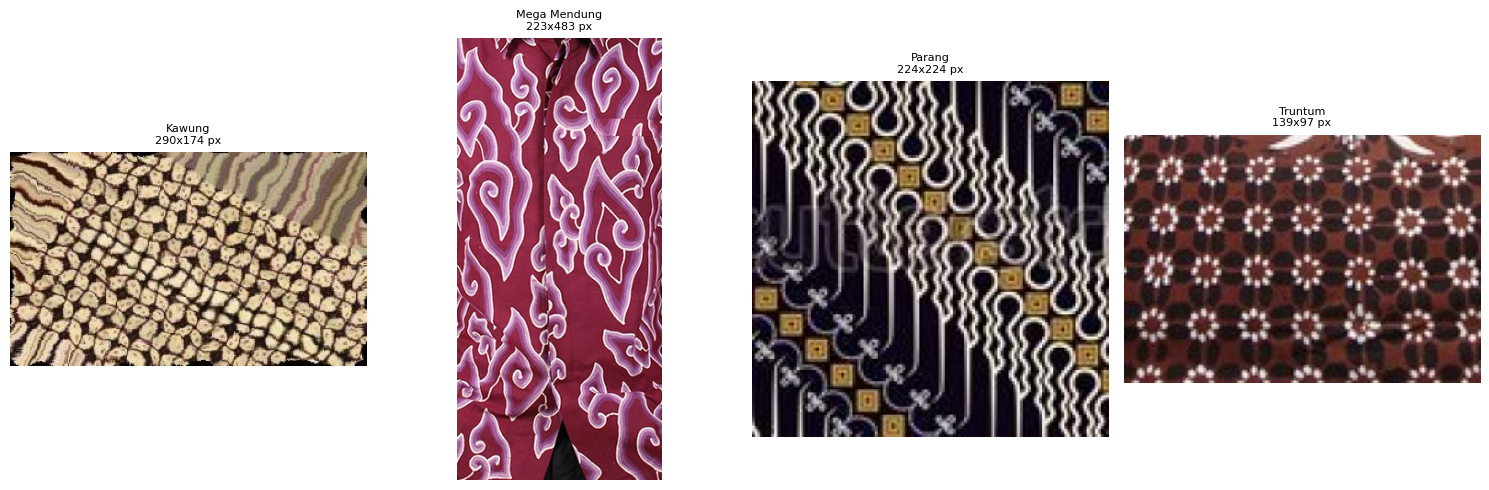

In [41]:
## Menampilkan Jumlah Dataset dari setiap kelas
total_dataset = 0
dataset = test_dir
folders = [folder for folder in os.listdir(dataset) if os.path.isdir(os.path.join(dataset, folder))]
# Check if folders is empty and handle it
if not folders:
    print("No folders found in the dataset directory. Please check the path.")
else:
    fig, axes = plt.subplots(1, len(folders), figsize=(15, 5))

    for i, folder in enumerate(folders):
        folder_path = os.path.join(dataset, folder)
        image_count = len(os.listdir(folder_path))
        total_dataset += image_count
        print(f"Jumlah data {folder}: {image_count}")

        # Menampilkan foto secara acak dari setiap folder
        try:
            image_files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
            if image_files:
                random_image = random.choice(image_files)
                image_path = os.path.join(folder_path, random_image)
                img = Image.open(image_path)
                width, height = img.size

                # Menampilkan gambar di subplot horizontal
                axes[i].imshow(img)
                axes[i].set_title(f"{folder}\n{width}x{height} px", fontsize=8)
                axes[i].axis('off')
            else:
                print(f"Tidak ada gambar yang ditemukan di folder '{folder}'")
        except Exception as e:
            print(f"Error menampilkan gambar dari folder '{folder}': {e}")

    print(f"Jumlah Dataset Rotate: {total_dataset}")
    plt.tight_layout()
    plt.show()

In [7]:
# menyalin gambar asal ke base

# Loop melalui setiap folder 
for label in os.listdir(asal_dir):
    label_path = os.path.join(asal_dir, label)
    
    # Pastikan ini adalah direktori
    if os.path.isdir(label_path):
        # Buat direktori label di gabungan_dir jika belum ada
        gabungan_label_dir = os.path.join(base_dir, label)
        if not os.path.exists(gabungan_label_dir):
            os.makedirs(gabungan_label_dir)
        
        # Loop melalui setiap gambar di folder label
        for image_name in os.listdir(label_path):
            image_path = os.path.join(label_path, image_name)
            
            # Salin gambar ke direktori gabungan
            shutil.copy(image_path, gabungan_label_dir)

print("Semua gambar dari telah disalin")

Semua gambar dari telah disalin


In [3]:
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224
IMAGE_SIZE = (IMAGE_WIDTH, IMAGE_HEIGHT)
BATCH_SIZE = 32
COLOR_CHANNELS = 3

In [35]:
def albumentations_aug(image):
    augment = Compose([ElasticTransform(alpha=120,          # meregangkan atau mengompresi, bergelombang atau melengkung 20-200
                                        sigma=10,           # seberapa mulus atau tajam distorsi yang terjadi 1-10 (semakin kecil semakin tajam)
                                        # alpha_affine=10,    # gambar tidak hanya bergelombang, tetapi juga bisa sedikit bergeser, berotasi, atau berubah ukurannya. 1-10
                                        p=1.0)])            # probabilitas augmentasi diterapkan pada gambar. 1.0: Augmentasi diterapkan di semua gambar input
    
    augmented = augment(image=image)["image"]
    # augmented = augmented.astype('float32') / 255.0
    return augmented


Found 1444 images belonging to 4 classes.


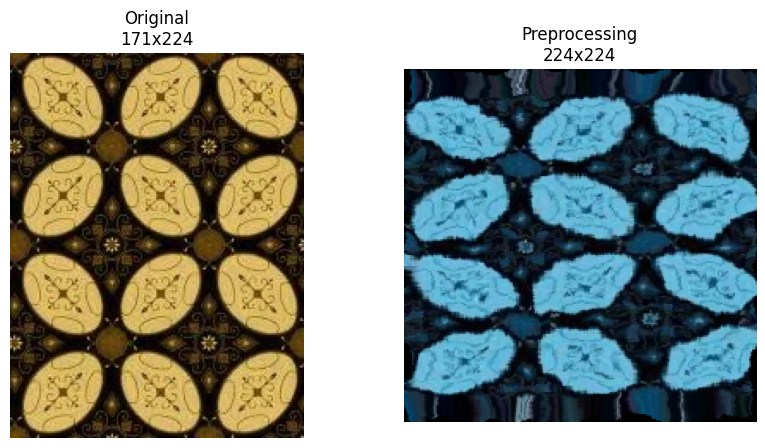

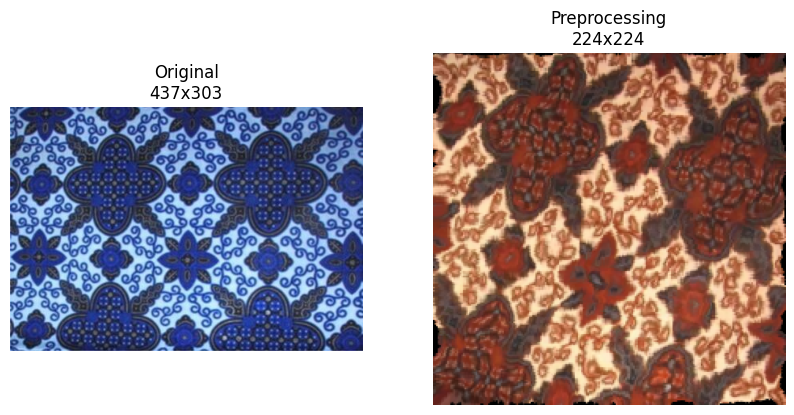

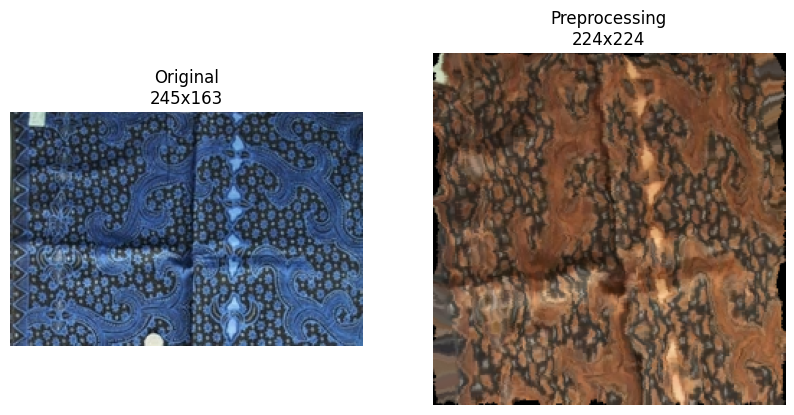

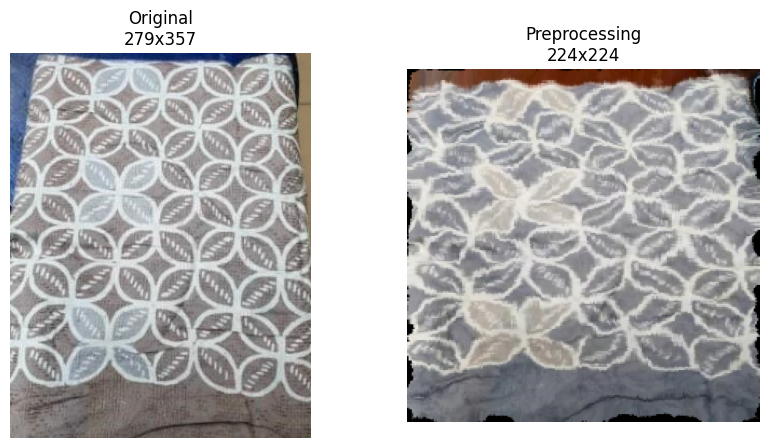

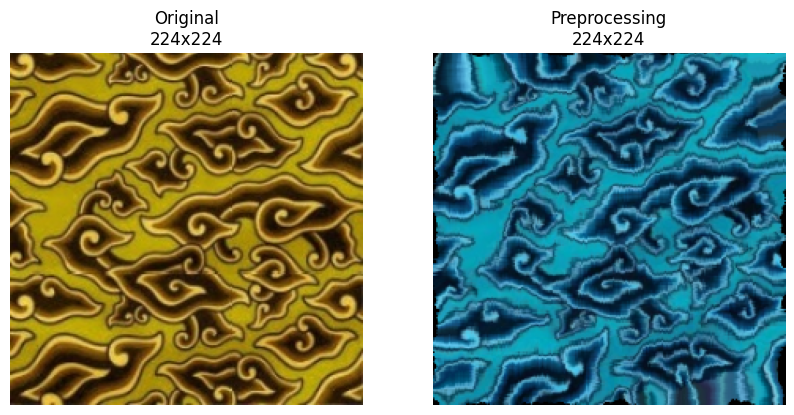

In [ ]:
datagen_aug = ImageDataGenerator(
    preprocessing_function=albumentations_aug,
    zoom_range=0.2,
    rotation_range=30,
)

test_doank = datagen_aug.flow_from_directory(
    directory=base_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

# Ambil satu batch gambar dari test generator
images, labels = next(test_doank)

# Tampilkan 5 gambar asli dan gambar yang telah diproses
for i in range(5):
    img_path = test_doank.filepaths[test_doank.index_array[i]]
    
    original_image = cv2.imread(img_path)

    augmented_image = images[i]

    height_original, width_original, _ = original_image.shape
    height_augmented, width_augmented, _ = augmented_image.shape

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    
    axes[0].imshow(original_image)
    axes[0].set_title(f"Original\n{width_original}x{height_original}")
    axes[0].axis("off")

    axes[1].imshow(augmented_image)
    axes[1].set_title(f"Preprocessing\n{width_augmented}x{height_augmented}")
    axes[1].axis("off")

    plt.show()

In [36]:
# Menambahkan dataset augmentasi di lokal

datagen_aug = ImageDataGenerator(
    preprocessing_function=albumentations_aug,
    zoom_range=0.2,
    rotation_range=30,
)

for label in os.listdir(base_dir):
    label_path = os.path.join(base_dir, label)
    
    if os.path.isdir(label_path):
        for file in os.listdir(label_path):
            img_path = os.path.join(label_path, file)
 
            # Load gambar
            img = load_img(img_path)
            img_array = img_to_array(img)
            img_array = np.expand_dims(img_array, axis=0)

            # Hasil augmentasi
            aug_iter = datagen_aug.flow(img_array, batch_size=1)

            for i in range(1):
                aug_img = next(aug_iter)[0].astype(np.uint8)
                aug_img_pil = array_to_img(aug_img)

                # Simpan gambar hasil augmentasi di lokasi asli
                save_path = os.path.join(label_path, f'aug_{file}')
                aug_img_pil.save(save_path)

print("Augmentasi selesai dan gambar berhasil disimpan.")

Augmentasi selesai dan gambar berhasil disimpan.


In [39]:
# Membagi data train dan test setelah augmentasi data

# Membuat folder untuk data train dan test jika belum ada
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Mendapatkan daftar kelas (subfolder dalam dataset)
classes = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]

# Membagi data per kelas
for cls in classes:
    cls_path = os.path.join(base_dir, cls)

    # Membuat folder kelas di train dan test
    os.makedirs(os.path.join(train_dir, cls), exist_ok=True)
    os.makedirs(os.path.join(test_dir, cls), exist_ok=True)

    # Mendapatkan daftar file gambar dalam kelas
    images = os.listdir(cls_path)

    # Membagi gambar menjadi 80% train dan 20% test
    train_imgs, test_imgs = train_test_split(images, test_size=0.2, random_state=42)

    # Memindahkan file ke folder train dan test
    for img in train_imgs:
        shutil.move(os.path.join(cls_path, img), os.path.join(train_dir, cls, img))
    for img in test_imgs:
        shutil.move(os.path.join(cls_path, img), os.path.join(test_dir, cls, img))

print("Pembagian dataset selesai.")

Pembagian dataset selesai.


In [4]:
# Fungsi preprocessing menggunakan CLAHE
# CLAHE akan meningkatkan kontras gambar sehingga fitur lebih terlihat
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
def preprocess_image(image):
    # Konversi nilai dari 0-1 ke 0-255 dan ubah tipe data ke uint8
    image = (image * 255).astype(np.uint8)
    
    # Konversi ke LAB color space
    lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    
    # Pisahkan channel L, A, dan B
    l, a, b = cv2.split(lab)
    
    # Terapkan CLAHE pada channel L (grayscale)
    l = clahe.apply(l)
    
    # Gabungkan kembali ke LAB
    lab = cv2.merge((l, a, b))
    
    # Konversi kembali ke RGB
    image = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)
    
    # Normalisasi kembali ke 0-1
    image = image / 255.0

    return image

In [5]:
datagen = ImageDataGenerator(
    preprocessing_function=preprocess_image
)

test_generator = datagen.flow_from_directory(
    directory=test_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False
)

Found 580 images belonging to 4 classes.


Found 580 images belonging to 4 classes.


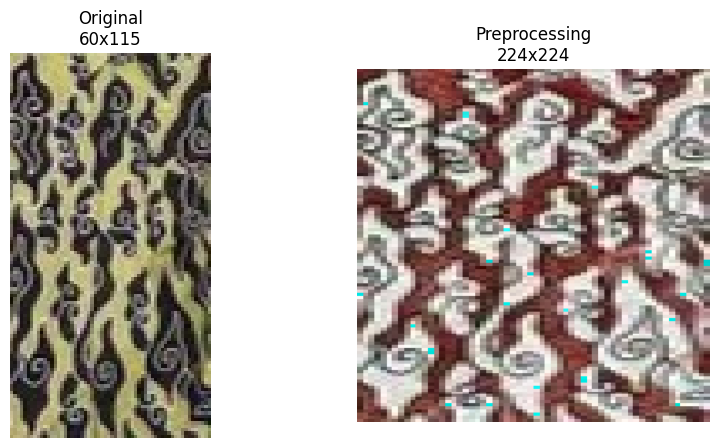

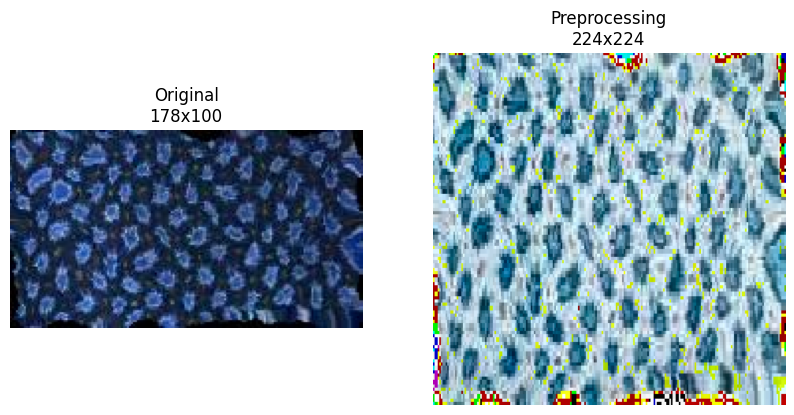

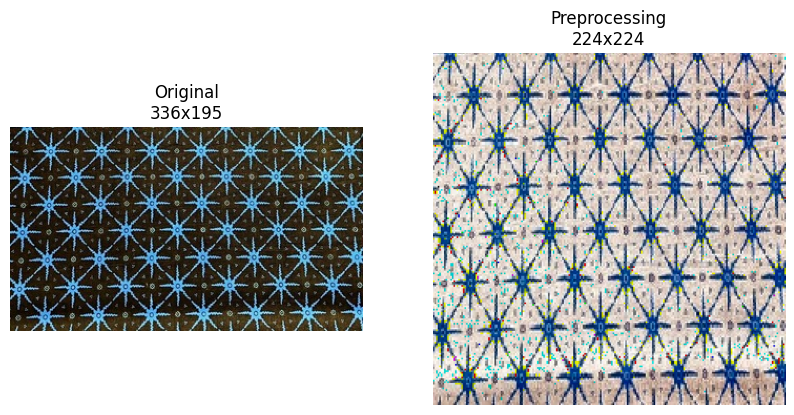

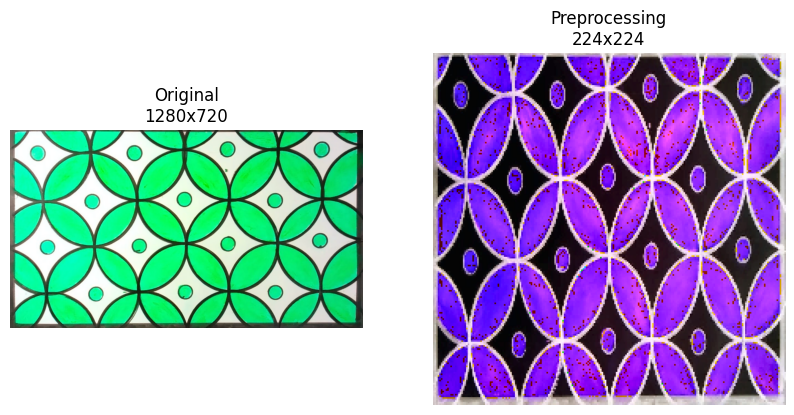

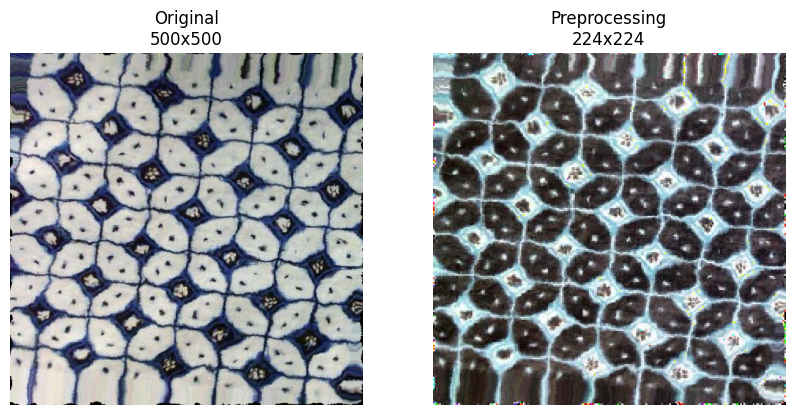

In [ ]:
# Ambil satu batch gambar dari test generator
images, labels = next(test_generator)

# Tampilkan 5 gambar asli dan gambar yang telah diproses
for i in range(5):
    img_path = test_generator.filepaths[test_generator.index_array[i]]
    
    original_image = cv2.imread(img_path)

    augmented_image = images[i]

    height_original, width_original, _ = original_image.shape
    height_augmented, width_augmented, _ = augmented_image.shape

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    
    axes[0].imshow(original_image)
    axes[0].set_title(f"Original\n{width_original}x{height_original}")
    axes[0].axis("off")

    axes[1].imshow(augmented_image)
    axes[1].set_title(f"Preprocessing\n{width_augmented}x{height_augmented}")
    axes[1].axis("off")

    plt.show()

In [48]:
# Ambil semua file gambar dari dataset asli
file_paths = []
labels = []

# Ambil file dari train_dir (data asli)
for label in os.listdir(train_dir):
    label_path = os.path.join(train_dir, label)
    if os.path.isdir(label_path):
        for file in os.listdir(label_path):
            file_paths.append(os.path.join(label_path, file))
            labels.append(label)

# Map label ke integer
unique_labels = sorted(set(labels))
label_map = {label: idx for idx, label in enumerate(unique_labels)}
integer_labels = [label_map[label] for label in labels]

print(f"Jumlah total gambar: {len(file_paths)}")
print(len(unique_labels))
print(label_map)
print(integer_labels)

Jumlah total gambar: 2308
4
{'Kawung': 0, 'Mega Mendung': 1, 'Parang': 2, 'Truntum': 3}
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,


🚀 Training Fold 1 😌

Found 1846 validated image filenames belonging to 4 classes.
Found 462 validated image filenames belonging to 4 classes.


c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
58/58 ━━━━━━━━━━━━━━━━━━━━ 200s 3s/step - accuracy: 0.4533 - loss: 1.3056 - val_accuracy: 0.8615 - val_loss: 0.5260 - learning_rate: 1.0000e-04
Epoch 2/25
58/58 ━━━━━━━━━━━━━━━━━━━━ 162s 3s/step - accuracy: 0.7128 - loss: 0.7196 - val_accuracy: 0.9242 - val_loss: 0.3006 - learning_rate: 1.0000e-04
Epoch 3/25
58/58 ━━━━━━━━━━━━━━━━━━━━ 173s 3s/step - accuracy: 0.8254 - loss: 0.4920 - val_accuracy: 0.9394 - val_loss: 0.2162 - learning_rate: 1.0000e-04
Epoch 4/25
58/58 ━━━━━━━━━━━━━━━━━━━━ 164s 3s/step - accuracy: 0.8795 - loss: 0.3345 - val_accuracy: 0.9545 - val_loss: 0.1471 - learning_rate: 1.0000e-04
Epoch 5/25
58/58 ━━━━━━━━━━━━━━━━━━━━ 168s 3s/step - accuracy: 0.9120 - loss: 0.2442 - val_accuracy: 0.9589 - val_loss: 0.1314 - learning_rate: 1.0000e-04
Epoch 6/25
58/58 ━━━━━━━━━━━━━━━━━━━━ 159s 3s/step - accuracy: 0.9247 - loss: 0.2274 - val_accuracy: 0.9481 - val_loss: 0.1196 - learning_rate: 1.0000e-04
Epoch 7/25
58/58 ━━━━━━━━━━━━━━━━━━━━ 161s 3s/step - accuracy: 0.9366 

C:\Users\ASUS\AppData\Local\Temp\ipykernel_312\3093743695.py:122: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([history.history['accuracy'], history.history['val_accuracy']], vert=True, patch_artist=True,
C:\Users\ASUS\AppData\Local\Temp\ipykernel_312\3093743695.py:131: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([history.history['loss'], history.history['val_loss']], vert=True, patch_artist=True,


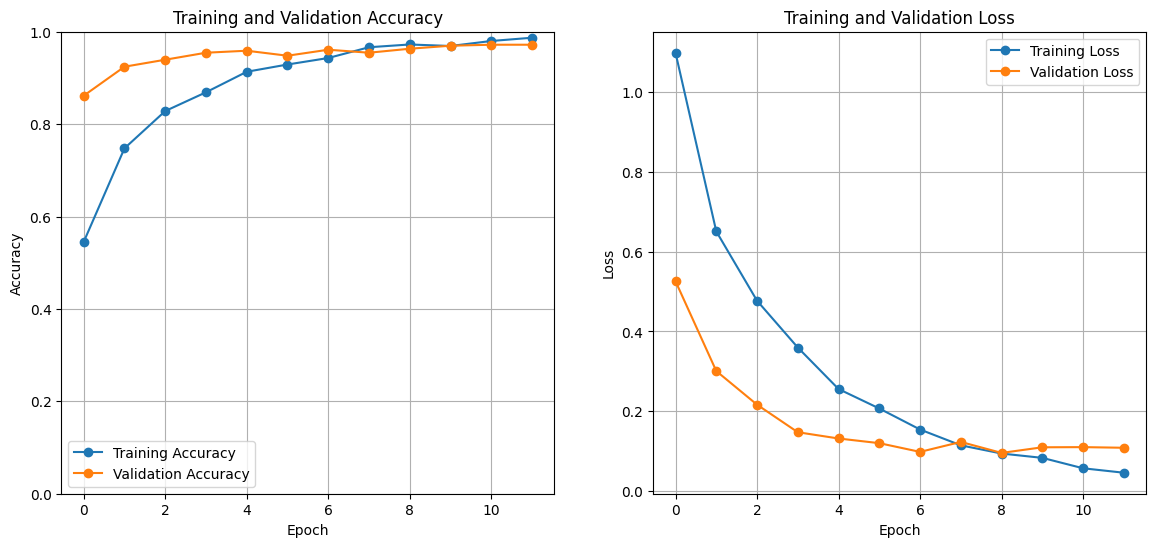

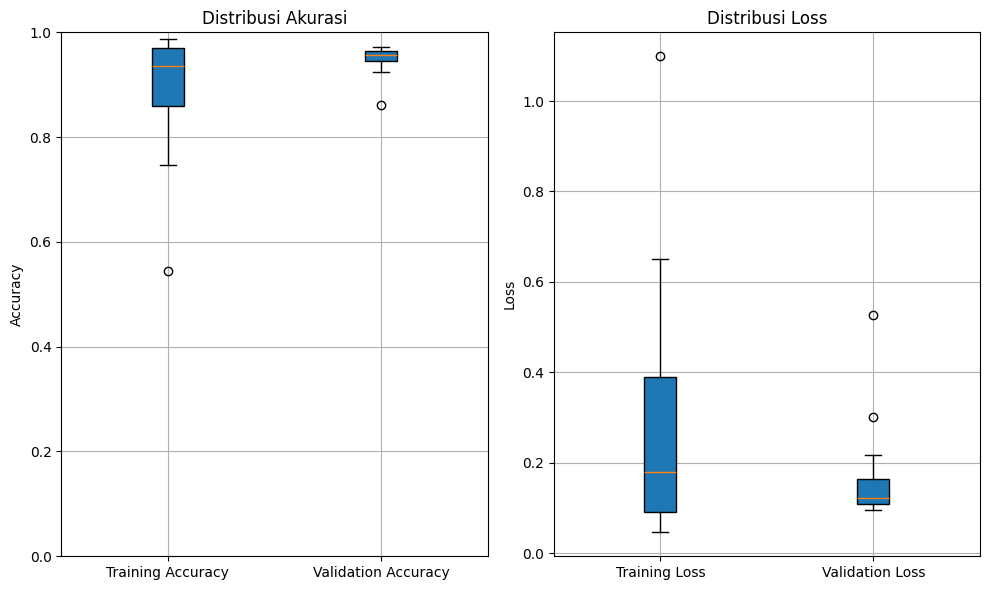


🚀 Training Fold 2 😌

Found 1846 validated image filenames belonging to 4 classes.
Found 462 validated image filenames belonging to 4 classes.


c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
58/58 ━━━━━━━━━━━━━━━━━━━━ 188s 3s/step - accuracy: 0.4136 - loss: 1.4006 - val_accuracy: 0.8290 - val_loss: 0.6344 - learning_rate: 1.0000e-04
Epoch 2/25
58/58 ━━━━━━━━━━━━━━━━━━━━ 156s 3s/step - accuracy: 0.6810 - loss: 0.7713 - val_accuracy: 0.9069 - val_loss: 0.3969 - learning_rate: 1.0000e-04
Epoch 3/25
58/58 ━━━━━━━━━━━━━━━━━━━━ 156s 3s/step - accuracy: 0.7946 - loss: 0.5195 - val_accuracy: 0.9069 - val_loss: 0.3130 - learning_rate: 1.0000e-04
Epoch 4/25
58/58 ━━━━━━━━━━━━━━━━━━━━ 157s 3s/step - accuracy: 0.8556 - loss: 0.3797 - val_accuracy: 0.9199 - val_loss: 0.2387 - learning_rate: 1.0000e-04
Epoch 5/25
58/58 ━━━━━━━━━━━━━━━━━━━━ 160s 3s/step - accuracy: 0.8870 - loss: 0.2958 - val_accuracy: 0.9242 - val_loss: 0.2171 - learning_rate: 1.0000e-04
Epoch 6/25
58/58 ━━━━━━━━━━━━━━━━━━━━ 157s 3s/step - accuracy: 0.9211 - loss: 0.2252 - val_accuracy: 0.9329 - val_loss: 0.2032 - learning_rate: 1.0000e-04
Epoch 7/25
58/58 ━━━━━━━━━━━━━━━━━━━━ 159s 3s/step - accuracy: 0.9390 

C:\Users\ASUS\AppData\Local\Temp\ipykernel_312\3093743695.py:122: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([history.history['accuracy'], history.history['val_accuracy']], vert=True, patch_artist=True,
C:\Users\ASUS\AppData\Local\Temp\ipykernel_312\3093743695.py:131: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([history.history['loss'], history.history['val_loss']], vert=True, patch_artist=True,


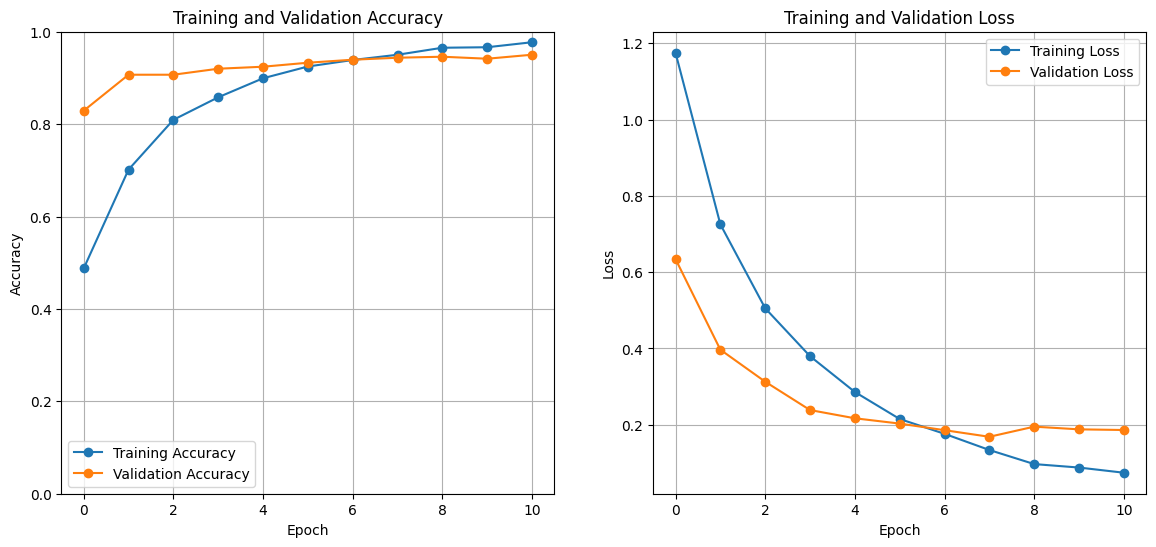

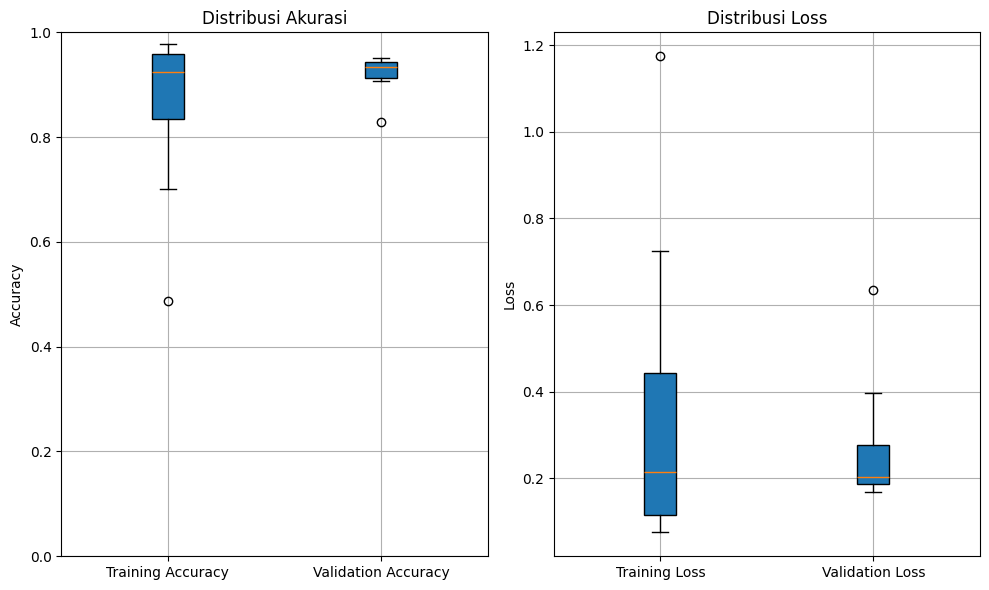


🚀 Training Fold 3 😌

Found 1846 validated image filenames belonging to 4 classes.
Found 462 validated image filenames belonging to 4 classes.


c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
58/58 ━━━━━━━━━━━━━━━━━━━━ 257s 4s/step - accuracy: 0.3688 - loss: 1.4531 - val_accuracy: 0.8377 - val_loss: 0.6355 - learning_rate: 1.0000e-04
Epoch 2/25
58/58 ━━━━━━━━━━━━━━━━━━━━ 185s 3s/step - accuracy: 0.6784 - loss: 0.7831 - val_accuracy: 0.8853 - val_loss: 0.3950 - learning_rate: 1.0000e-04
Epoch 3/25
58/58 ━━━━━━━━━━━━━━━━━━━━ 187s 3s/step - accuracy: 0.7803 - loss: 0.5522 - val_accuracy: 0.9069 - val_loss: 0.2824 - learning_rate: 1.0000e-04
Epoch 4/25
58/58 ━━━━━━━━━━━━━━━━━━━━ 184s 3s/step - accuracy: 0.8446 - loss: 0.4076 - val_accuracy: 0.9134 - val_loss: 0.2679 - learning_rate: 1.0000e-04
Epoch 5/25
58/58 ━━━━━━━━━━━━━━━━━━━━ 177s 3s/step - accuracy: 0.9021 - loss: 0.3038 - val_accuracy: 0.9156 - val_loss: 0.2348 - learning_rate: 1.0000e-04
Epoch 6/25
58/58 ━━━━━━━━━━━━━━━━━━━━ 173s 3s/step - accuracy: 0.9137 - loss: 0.2331 - val_accuracy: 0.9351 - val_loss: 0.2048 - learning_rate: 1.0000e-04
Epoch 7/25
58/58 ━━━━━━━━━━━━━━━━━━━━ 163s 3s/step - accuracy: 0.9232 

C:\Users\ASUS\AppData\Local\Temp\ipykernel_312\3093743695.py:122: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([history.history['accuracy'], history.history['val_accuracy']], vert=True, patch_artist=True,
C:\Users\ASUS\AppData\Local\Temp\ipykernel_312\3093743695.py:131: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([history.history['loss'], history.history['val_loss']], vert=True, patch_artist=True,


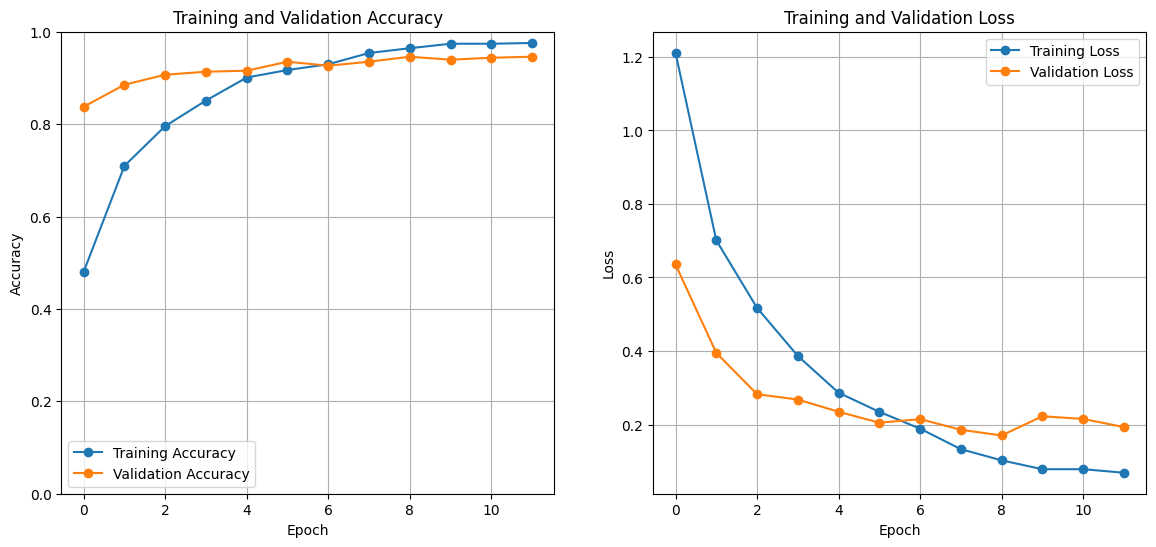

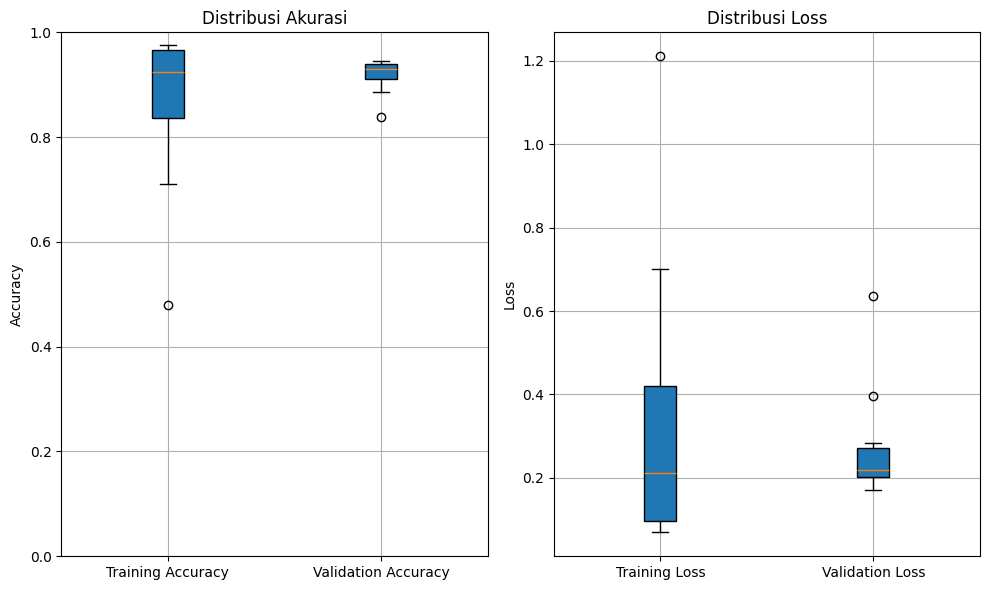


🚀 Training Fold 4 😌

Found 1847 validated image filenames belonging to 4 classes.
Found 461 validated image filenames belonging to 4 classes.


c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
58/58 ━━━━━━━━━━━━━━━━━━━━ 180s 3s/step - accuracy: 0.4229 - loss: 1.3700 - val_accuracy: 0.8330 - val_loss: 0.5791 - learning_rate: 1.0000e-04
Epoch 2/25
58/58 ━━━━━━━━━━━━━━━━━━━━ 159s 3s/step - accuracy: 0.7141 - loss: 0.7184 - val_accuracy: 0.8937 - val_loss: 0.3526 - learning_rate: 1.0000e-04
Epoch 3/25
58/58 ━━━━━━━━━━━━━━━━━━━━ 157s 3s/step - accuracy: 0.8239 - loss: 0.4906 - val_accuracy: 0.9219 - val_loss: 0.2565 - learning_rate: 1.0000e-04
Epoch 4/25
58/58 ━━━━━━━━━━━━━━━━━━━━ 158s 3s/step - accuracy: 0.8697 - loss: 0.3504 - val_accuracy: 0.9284 - val_loss: 0.2214 - learning_rate: 1.0000e-04
Epoch 5/25
58/58 ━━━━━━━━━━━━━━━━━━━━ 159s 3s/step - accuracy: 0.8978 - loss: 0.2890 - val_accuracy: 0.9393 - val_loss: 0.1803 - learning_rate: 1.0000e-04
Epoch 6/25
58/58 ━━━━━━━━━━━━━━━━━━━━ 160s 3s/step - accuracy: 0.9156 - loss: 0.2220 - val_accuracy: 0.9393 - val_loss: 0.1580 - learning_rate: 1.0000e-04
Epoch 7/25
58/58 ━━━━━━━━━━━━━━━━━━━━ 161s 3s/step - accuracy: 0.9402 

C:\Users\ASUS\AppData\Local\Temp\ipykernel_312\3093743695.py:122: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([history.history['accuracy'], history.history['val_accuracy']], vert=True, patch_artist=True,
C:\Users\ASUS\AppData\Local\Temp\ipykernel_312\3093743695.py:131: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([history.history['loss'], history.history['val_loss']], vert=True, patch_artist=True,


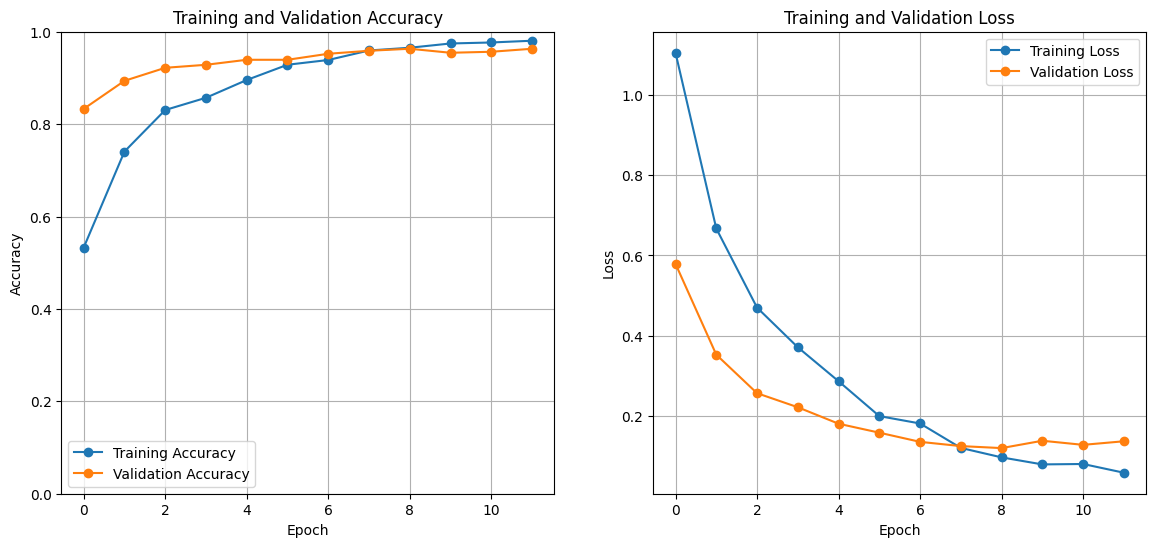

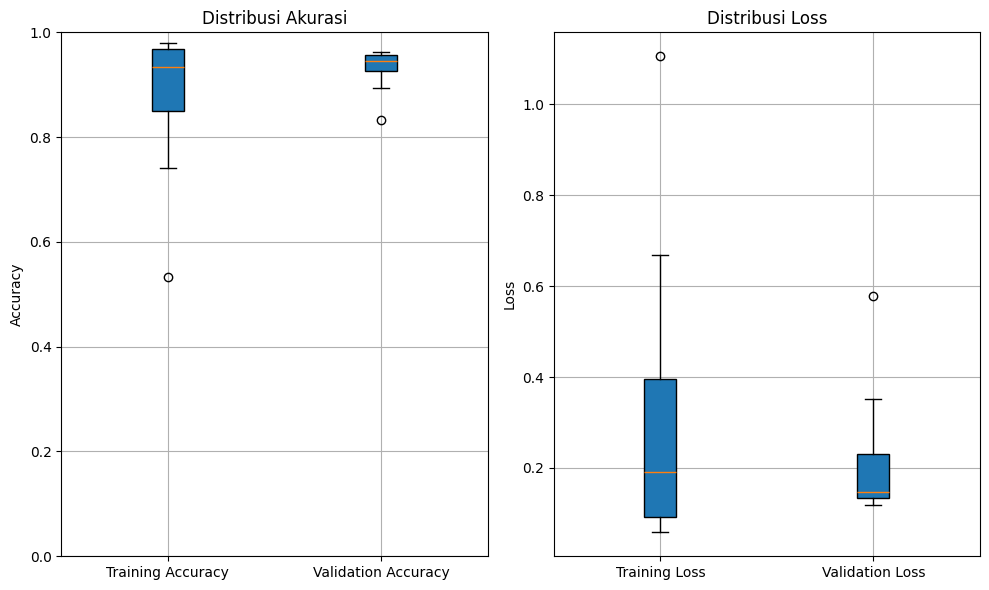


🚀 Training Fold 5 😌

Found 1847 validated image filenames belonging to 4 classes.
Found 461 validated image filenames belonging to 4 classes.


c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
58/58 ━━━━━━━━━━━━━━━━━━━━ 186s 3s/step - accuracy: 0.4652 - loss: 1.4199 - val_accuracy: 0.8720 - val_loss: 0.4994 - learning_rate: 1.0000e-04
Epoch 2/25
58/58 ━━━━━━━━━━━━━━━━━━━━ 157s 3s/step - accuracy: 0.7363 - loss: 0.6911 - val_accuracy: 0.8872 - val_loss: 0.3706 - learning_rate: 1.0000e-04
Epoch 3/25
58/58 ━━━━━━━━━━━━━━━━━━━━ 157s 3s/step - accuracy: 0.8328 - loss: 0.4346 - val_accuracy: 0.9176 - val_loss: 0.2463 - learning_rate: 1.0000e-04
Epoch 4/25
58/58 ━━━━━━━━━━━━━━━━━━━━ 155s 3s/step - accuracy: 0.8719 - loss: 0.3269 - val_accuracy: 0.9219 - val_loss: 0.2638 - learning_rate: 1.0000e-04
Epoch 5/25
58/58 ━━━━━━━━━━━━━━━━━━━━ 156s 3s/step - accuracy: 0.9114 - loss: 0.2318 - val_accuracy: 0.9349 - val_loss: 0.1822 - learning_rate: 1.0000e-04
Epoch 6/25
58/58 ━━━━━━━━━━━━━━━━━━━━ 157s 3s/step - accuracy: 0.9370 - loss: 0.1968 - val_accuracy: 0.9414 - val_loss: 0.1756 - learning_rate: 1.0000e-04
Epoch 7/25
58/58 ━━━━━━━━━━━━━━━━━━━━ 156s 3s/step - accuracy: 0.9712 

C:\Users\ASUS\AppData\Local\Temp\ipykernel_312\3093743695.py:122: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([history.history['accuracy'], history.history['val_accuracy']], vert=True, patch_artist=True,
C:\Users\ASUS\AppData\Local\Temp\ipykernel_312\3093743695.py:131: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([history.history['loss'], history.history['val_loss']], vert=True, patch_artist=True,


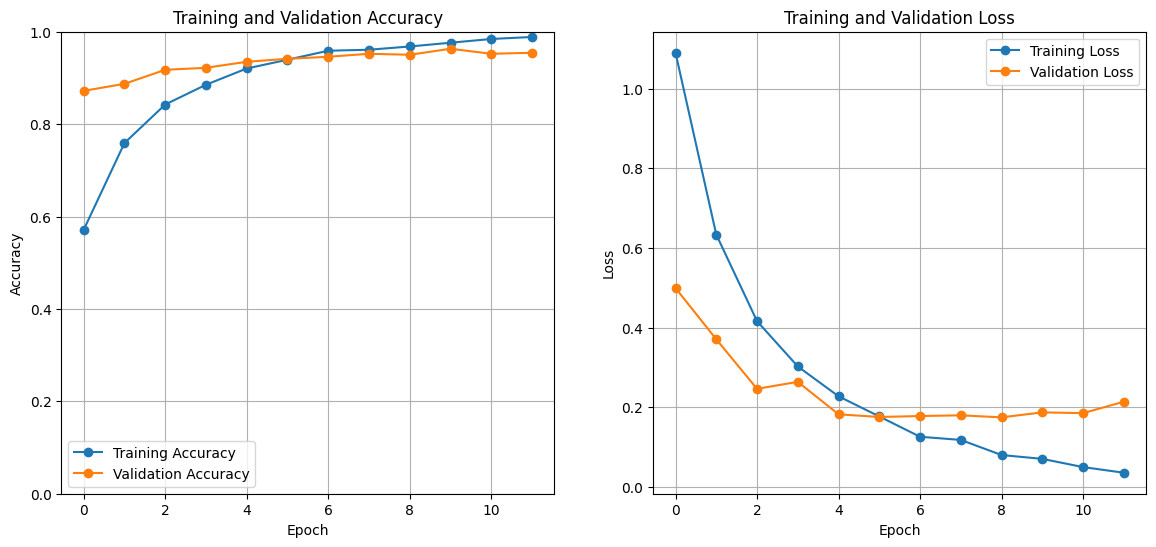

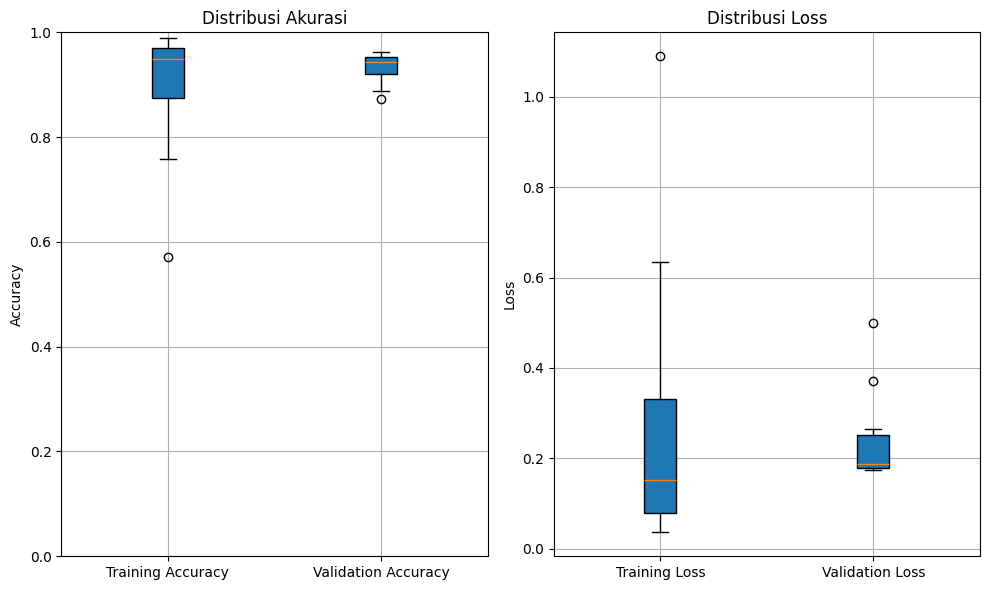

In [49]:
# Implementasi Kfold
EPOCH = 25
kf = KFold(n_splits=5, shuffle=True, random_state=42) # tambahkan random_state untuk reproduksibilitas

# Direktori untuk menyimpan model terbaik
best_model_dir = r'.\keras aug\zoom+elastic+rotate'
# Fungsi untuk membuat model
def create_model(num_classes):
    base_model = DenseNet169(
        weights='imagenet', 
        include_top=False, 
        input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, COLOR_CHANNELS))
    
    # Membekukan 596 layer awal dari DenseNet169
    for layer in base_model.layers[:-10]:  
        layer.trainable = False

    # Custom Layer base model
    x = base_model.output
    x = Conv2D(32, (4, 4), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.3)(x)
    x = Dense(64, activation='relu', name='FC2')(x) 
    x = Dropout(0.3)(x)
    x = Flatten()(x)
    x = Dropout(0.3)(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    model.compile(optimizer=RMSprop(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

fold_var = 1 # Inisialisasi variabel fold
for train_index, val_index in kf.split(file_paths):
    print(f"\n🚀 Training Fold {fold_var} 😌\n")

    # Split train and validation sets
    train_files, val_files = np.array(file_paths)[train_index], np.array(file_paths)[val_index]
    train_labels, val_labels = np.array(integer_labels)[train_index], np.array(integer_labels)[val_index]
    
    # Convert integer labels to class names
    df_train = pd.DataFrame({"filename": train_files, "class": [unique_labels[i] for i in train_labels]})
    df_val = pd.DataFrame({"filename": val_files, "class": [unique_labels[i] for i in val_labels]})

    train_generator = datagen.flow_from_dataframe(
        dataframe=df_train,       # DataFrame yang berisi informasi gambar (filename dan class)
        x_col="filename",         # Kolom yang berisi path ke gambar
        y_col="class",            # Kolom yang berisi label kelas gambar
        target_size=IMAGE_SIZE,   # Ukuran gambar yang akan diubah sebelum masuk ke model
        batch_size=BATCH_SIZE,    # Jumlah gambar yang akan diproses dalam satu batch
        class_mode="categorical", # Mode klasifikasi (multikategori)
        color_mode="rgb",         # Format warna gambar (RGB)
        shuffle=True
    )
    
    val_generator = datagen.flow_from_dataframe(
        dataframe=df_val,
        x_col="filename",
        y_col="class",
        target_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,
        class_mode="categorical",
        color_mode="rgb",
        shuffle=True
    )

    # Callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)
    model_checkpoint = ModelCheckpoint(os.path.join(best_model_dir, f'gabungan_model_{fold_var}.keras'), monitor='val_loss', save_best_only=True)
    
    # Buat Learning Rate Scheduler
    lr_scheduler = ReduceLROnPlateau(
        monitor='val_accuracy',     
        factor=0.1,             
        patience=3,             # Jika val_loss tidak membaik setelah 3 epoch, LR akan diturunkan
        min_lr=1e-6,            
        verbose=1               
    )

    num_classes = 4 
    model = create_model(num_classes)

    # Training Model
    history = model.fit(
        train_generator,
        epochs=EPOCH,
        validation_data=val_generator,
        callbacks=[early_stopping, model_checkpoint, lr_scheduler]
    )

    # Plot grafik akurasi dan loss dengan format yang lebih baik
    plt.figure(figsize=(14, 6))

    # Plot Training and Validation Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)  # Menentukan rentang y antara 0 dan 1 (untuk akurasi)
    plt.grid(True)
    plt.legend()

    # Plot Training and Validation Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss', marker='o')
    plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.legend()

    # Buat figure Box Plot
    plt.figure(figsize=(10, 6))
    
    # Boxplot untuk Training & Validation Accuracy
    plt.subplot(1, 2, 1)
    plt.boxplot([history.history['accuracy'], history.history['val_accuracy']], vert=True, patch_artist=True,
                labels=['Training Accuracy', 'Validation Accuracy'])
    plt.title('Distribusi Akurasi')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)
    plt.grid(True)
    
    # Boxplot untuk Training & Validation Loss
    plt.subplot(1, 2, 2)
    plt.boxplot([history.history['loss'], history.history['val_loss']], vert=True, patch_artist=True,
                labels=['Training Loss', 'Validation Loss'])
    plt.title('Distribusi Loss')
    plt.ylabel('Loss')
    plt.grid(True)

    # Tampilkan grafik
    plt.tight_layout()
    plt.show()

    fold_var += 1

In [52]:
import numpy as np

# Contoh hasil akurasi dari 5 fold
accuracies = [96.32, 94.37, 94.59, 96.31, 95.01]

# Menghitung standar deviasi
std_dev = np.std(accuracies)

print(f"Standar Deviasi Akurasi Model gabungan: {std_dev:.4f}")

Standar Deviasi Akurasi Model gabungan: 0.8380





Kfold 1 ...


c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


19/19 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step


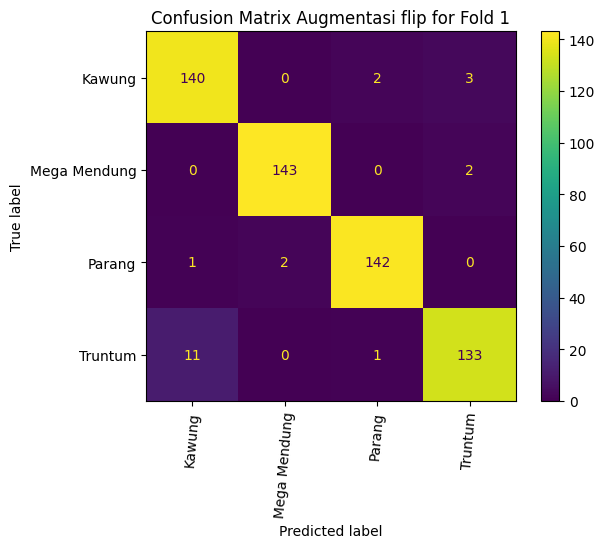

Classification Report
              precision    recall  f1-score   support

      Kawung     0.9211    0.9655    0.9428       145
Mega Mendung     0.9862    0.9862    0.9862       145
      Parang     0.9793    0.9793    0.9793       145
     Truntum     0.9638    0.9172    0.9399       145

    accuracy                         0.9621       580
   macro avg     0.9626    0.9621    0.9621       580
weighted avg     0.9626    0.9621    0.9621       580




Kfold 2 ...
19/19 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step


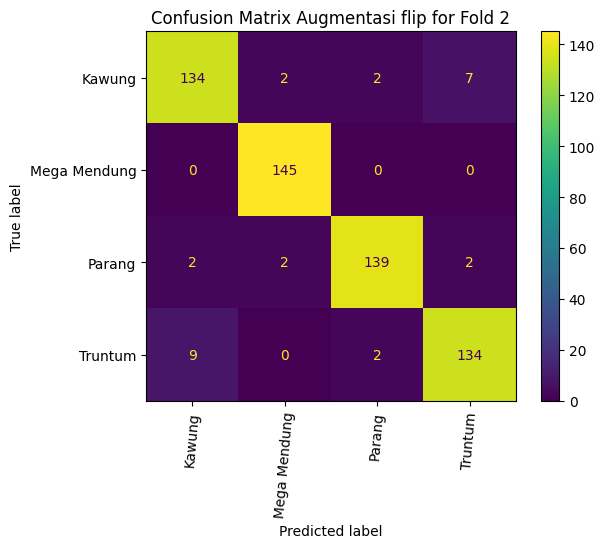

Classification Report
              precision    recall  f1-score   support

      Kawung     0.9241    0.9241    0.9241       145
Mega Mendung     0.9732    1.0000    0.9864       145
      Parang     0.9720    0.9586    0.9653       145
     Truntum     0.9371    0.9241    0.9306       145

    accuracy                         0.9517       580
   macro avg     0.9516    0.9517    0.9516       580
weighted avg     0.9516    0.9517    0.9516       580




Kfold 3 ...
19/19 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step


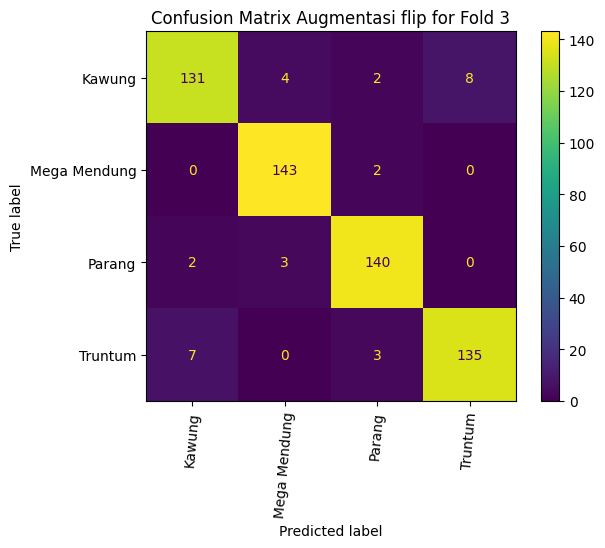

Classification Report
              precision    recall  f1-score   support

      Kawung     0.9357    0.9034    0.9193       145
Mega Mendung     0.9533    0.9862    0.9695       145
      Parang     0.9524    0.9655    0.9589       145
     Truntum     0.9441    0.9310    0.9375       145

    accuracy                         0.9466       580
   macro avg     0.9464    0.9466    0.9463       580
weighted avg     0.9464    0.9466    0.9463       580




Kfold 4 ...
19/19 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step


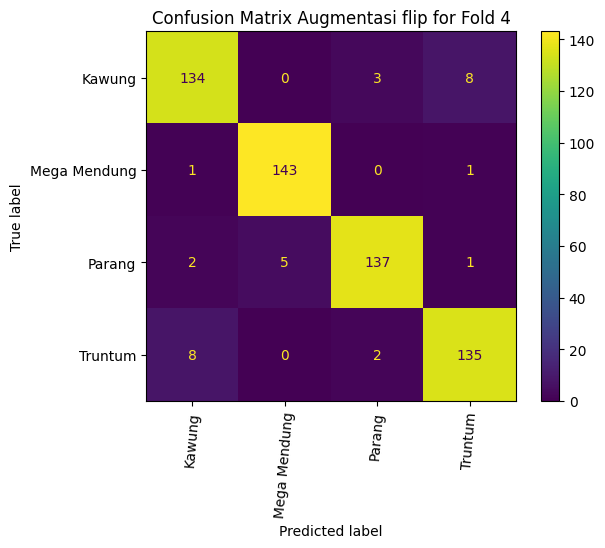

Classification Report
              precision    recall  f1-score   support

      Kawung     0.9241    0.9241    0.9241       145
Mega Mendung     0.9662    0.9862    0.9761       145
      Parang     0.9648    0.9448    0.9547       145
     Truntum     0.9310    0.9310    0.9310       145

    accuracy                         0.9466       580
   macro avg     0.9465    0.9466    0.9465       580
weighted avg     0.9465    0.9466    0.9465       580




Kfold 5 ...
19/19 ━━━━━━━━━━━━━━━━━━━━ 54s 3s/step


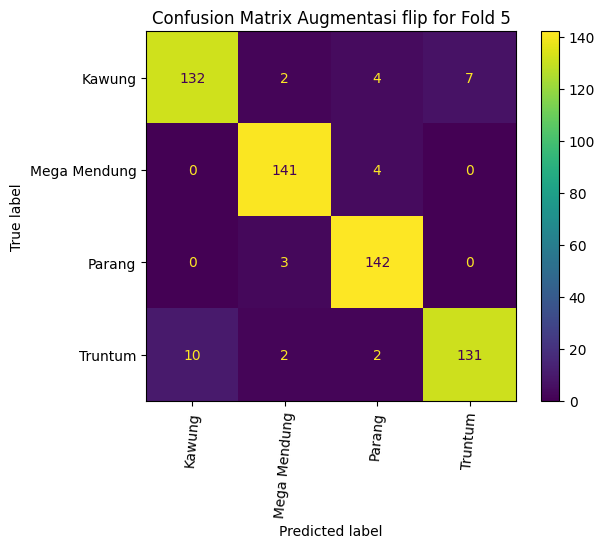

Classification Report
              precision    recall  f1-score   support

      Kawung     0.9296    0.9103    0.9199       145
Mega Mendung     0.9527    0.9724    0.9625       145
      Parang     0.9342    0.9793    0.9562       145
     Truntum     0.9493    0.9034    0.9258       145

    accuracy                         0.9414       580
   macro avg     0.9414    0.9414    0.9411       580
weighted avg     0.9414    0.9414    0.9411       580



In [6]:
def evaluate_model(fold_count, test_generator, model_path='./keras aug/zoom+elastic+rotate/gabungan_model_'):
    for fold in range(1, fold_count + 1):
        print('\n\n')
        print(f"Kfold {fold} ...")
        loaded_model = load_model(f'{model_path}{fold}.keras')
        
        predictions = loaded_model.predict(test_generator)
        
        # Get class labels
        class_labels = list(test_generator.class_indices.keys())
        
        # Get the true and predicted class indices
        y_true = test_generator.classes
        y_pred = np.argmax(predictions, axis=1)
        
        # Confusion Matrix Display
        conf_matrix = confusion_matrix(y_true, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_labels)
        
        disp.plot(cmap='viridis')
        plt.title(f'Confusion Matrix Augmentasi flip for Fold {fold}')
        plt.xticks(rotation=85)
        plt.show()
        
        class_report = classification_report(y_true, y_pred, target_names=class_labels, digits=4)
        print('Classification Report')
        print(class_report)

evaluate_model(fold_count=5, test_generator=test_generator)




Evaluasi KFold 1 ...


c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


19/19 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step
Skor AUC (macro-average) untuk Fold 1: 0.9947


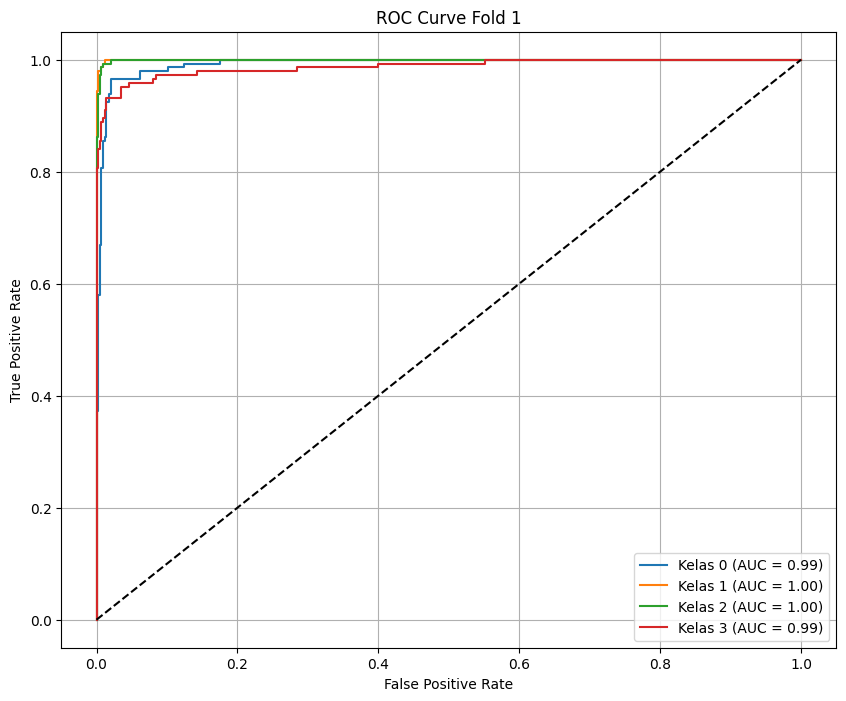




Evaluasi KFold 2 ...
19/19 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step
Skor AUC (macro-average) untuk Fold 2: 0.9949


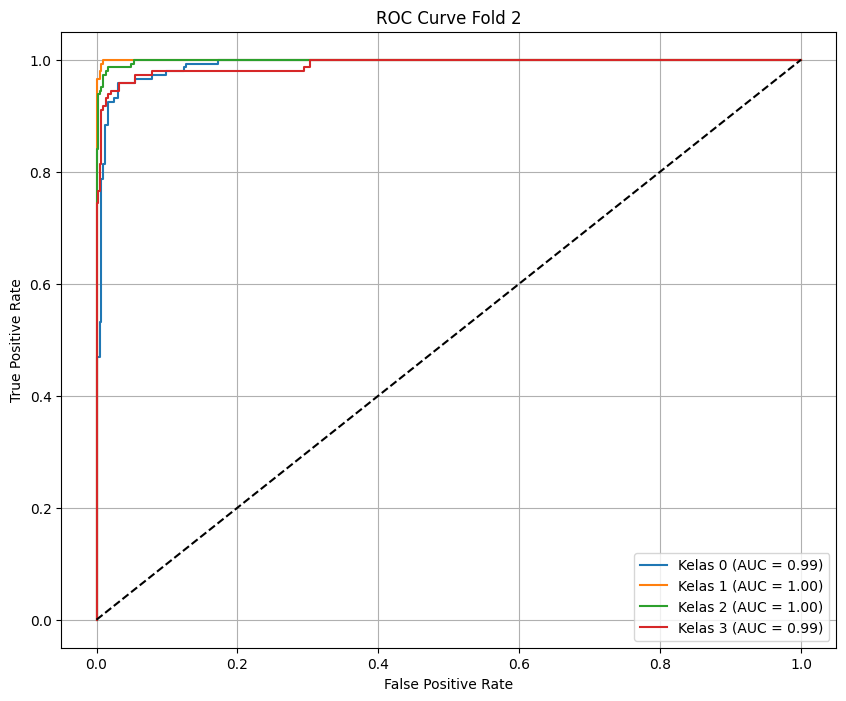




Evaluasi KFold 3 ...
19/19 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step
Skor AUC (macro-average) untuk Fold 3: 0.9946


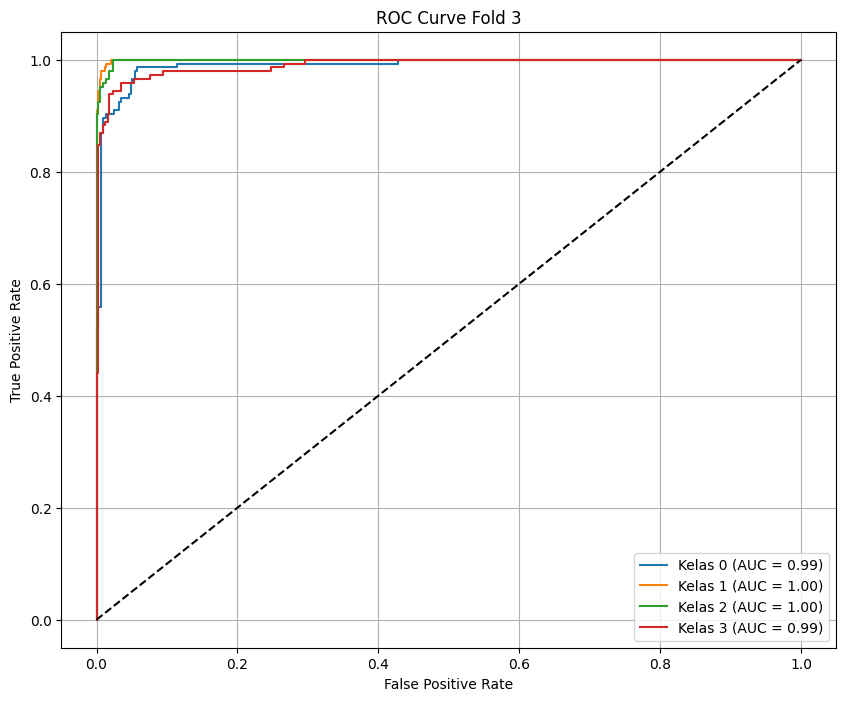




Evaluasi KFold 4 ...
19/19 ━━━━━━━━━━━━━━━━━━━━ 58s 3s/step
Skor AUC (macro-average) untuk Fold 4: 0.9962


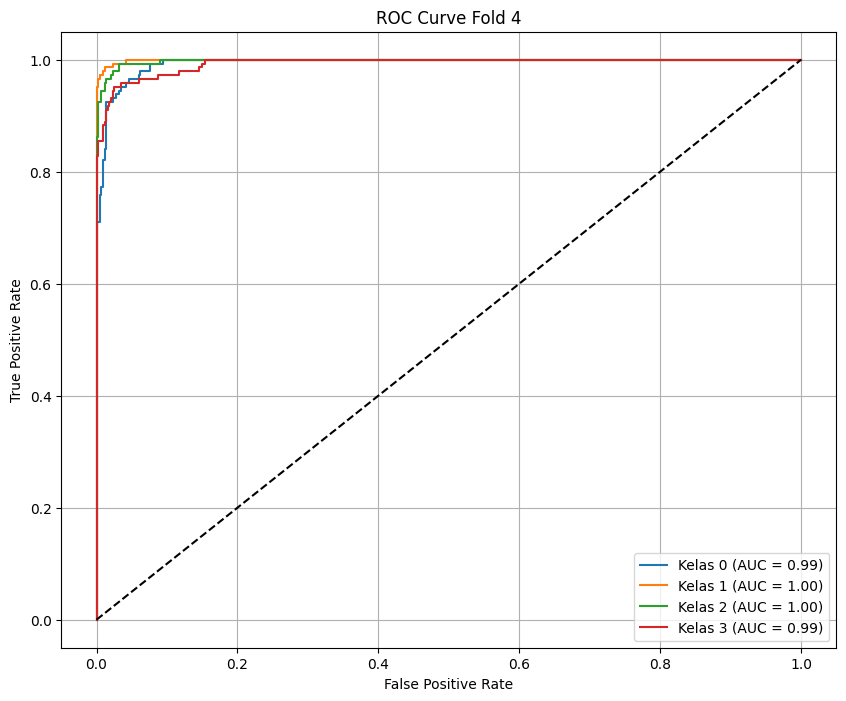




Evaluasi KFold 5 ...
19/19 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step
Skor AUC (macro-average) untuk Fold 5: 0.9953


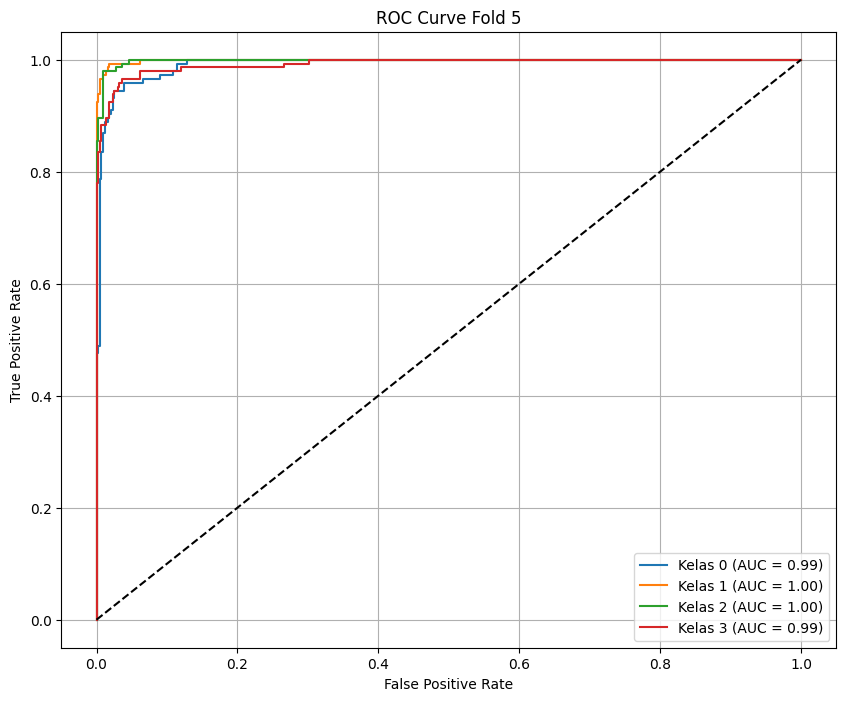

In [6]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize

def evaluate_model(fold_count, test_generator, model_path='./keras aug/zoom+elastic+rotate/gabungan_model_'):
    for fold in range(1, fold_count + 1):
        print('\n\n')
        print(f"Evaluasi KFold {fold} ...")
        
        # Load model
        loaded_model = load_model(f'{model_path}{fold}.keras')

        # Prediksi pada data testing
        predictions = loaded_model.predict(test_generator)

        # Ambil label sebenarnya dari generator
        true_labels = test_generator.classes
        
        # Konversi label ke bentuk one-hot
        num_classes = predictions.shape[1]
        y_true = label_binarize(true_labels, classes=range(num_classes))
        
        # Hitung skor AUC macro
        auc_score = roc_auc_score(y_true, predictions, average='macro', multi_class='ovr')
        print(f"Skor AUC (macro-average) untuk Fold {fold}: {auc_score:.4f}")

        # Plot ROC Curve untuk setiap kelas
        fpr = dict()
        tpr = dict()
        roc_auc = dict()

        for i in range(num_classes):
            fpr[i], tpr[i], _ = roc_curve(y_true[:, i], predictions[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        # Plot semua ROC dalam 1 grafik
        plt.figure(figsize=(10, 8))
        for i in range(num_classes):
            plt.plot(fpr[i], tpr[i], label=f'Kelas {i} (AUC = {roc_auc[i]:.2f})')

        plt.plot([0, 1], [0, 1], 'k--')  # Garis diagonal random guess
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve Fold {fold}')
        plt.legend(loc='lower right')
        plt.grid(True)
        plt.show()

evaluate_model(fold_count=5, test_generator=test_generator)